### Import Data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mpl_toolkits.mplot3d import Axes3D

file path did not work
file path did not work
file path did not work


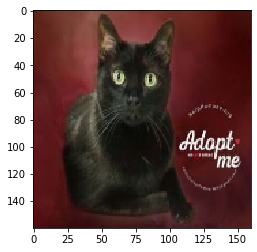

In [2]:
data = []
dirpath = "datasets/cat_imgs"
folders = ['tabby', 'siamese','bombay']
for folder in folders:
    path = os.path.join(dirpath, folder)
    for img_path in os.listdir(path):
        try: 
            image_arr = cv2.imread(os.path.join(path, img_path))
            img_rgb=cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(img_rgb,(160, 160))
            data.append([new_array, folders.index(folder)])
            plt.imshow(new_array)
        except:
            print("file path did not work")

In [3]:
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)

In [4]:
X = np.array(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [7]:
y_train = pd.Series(y_train, name = 'target')
y_test = pd.Series(y_test, name = 'target')

In [8]:
cats = []
for i, img in enumerate(X_train):
    cat = pd.Series(img.flatten(), name = i)
    cats.append(cat)

In [9]:
cats_test=[]
for a, each in enumerate(X_test):
    cat_test = pd.Series(each.flatten(), name = a)
    cats_test.append(cat_test)

In [10]:
cats = pd.DataFrame(cats)
cats_test = pd.DataFrame(cats_test)

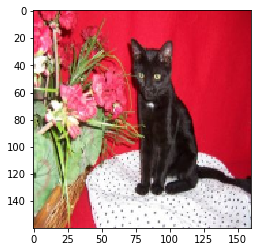

In [11]:
#show original training image
plt.imshow(cats.iloc[8].values.reshape(160, 160, 3))

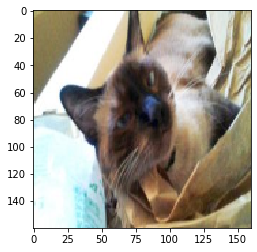

In [12]:
#show original testing image
plt.imshow(cats_test.iloc[8].values.reshape(160, 160, 3))

### Image Reconstruction with PCA

In [13]:
#Standardize the data before fit it to PCA
ss = StandardScaler()
train_img = ss.fit_transform(cats)
test_img = ss.transform(cats_test)

In [14]:
# Use PCA to reduce the training and testing datasets to 3 dimensional datasets
pca = PCA(n_components = 3)
cats_train_pca = pca.fit_transform(train_img)
cats_test_pca = pca.transform(test_img)

In [15]:
pca_train = pd.DataFrame(columns=['pc1','pc2'])
pca_test = pd.DataFrame(columns=['pc1','pc2'])

In [16]:
pca_train['pc1'] = cats_train_pca[:,0]
pca_train['pc2'] = cats_train_pca[:,1]
pca_train['pc3'] = cats_train_pca[:,2]

In [17]:
pca_test['pc1'] = cats_test_pca[:,0]
pca_test['pc2'] = cats_test_pca[:,1]

In [18]:
pca_train_df = pd.concat([pca_train, y_train], axis =1)
pca_test_df = pd.concat([pca_test, y_test], axis =1)

Text(0, 0.5, 'principle component 2')

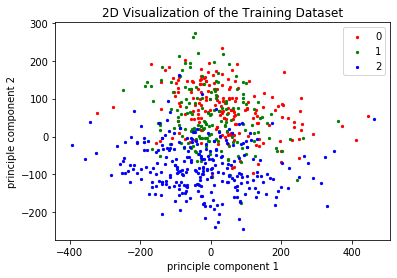

In [19]:
# plot the training dataset as a 2 dimentioanl dataset 
# using the top two principle components which is measured by their eigenvalues
label = [0, 1,2]
colors = ['r', 'g', 'b']
for target, color in zip(label,colors):
    indicesToKeep = pca_train_df ['target'] == target
    plt.scatter(pca_train_df.loc[indicesToKeep, 'pc1']
               , pca_train_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 5)
plt.legend(label)
plt.title('2D Visualization of the Training Dataset')
plt.xlabel('principle component 1')
plt.ylabel('principle component 2')

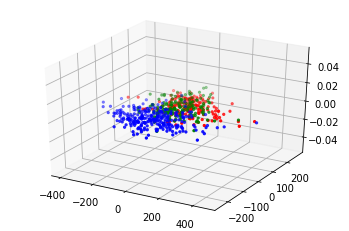

In [20]:
#Adding an additional cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
label = [0, 1,2]
colors = ['r', 'g', 'b']
for target, color in zip(label,colors):
    indicesToKeep = pca_train_df ['target'] == target
    ax.scatter3D(pca_train_df.loc[indicesToKeep, 'pc1']
               , pca_train_df.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 5)

1. Use a for loop to try out how different components affact image recreation
2. Reverse PCA using the number of principle components to reconstruct original image

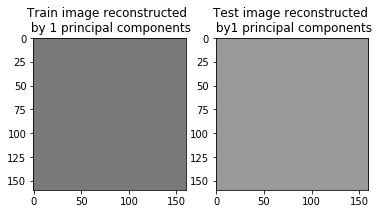

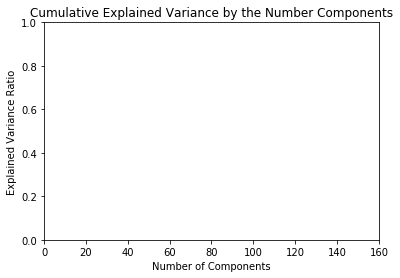

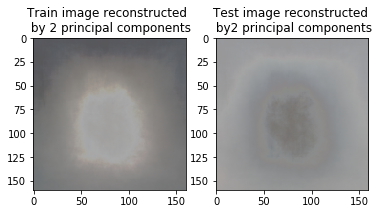

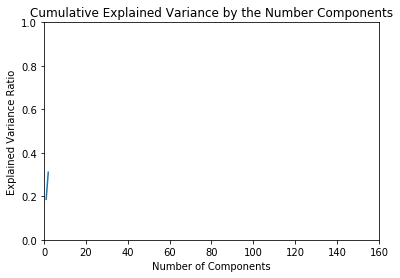

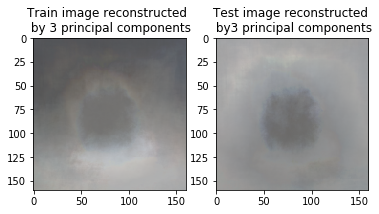

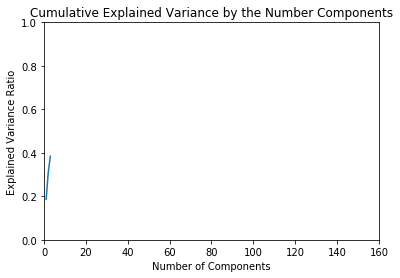

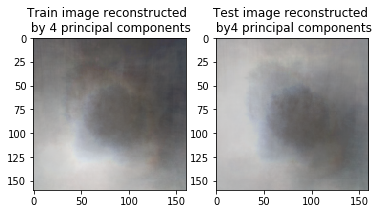

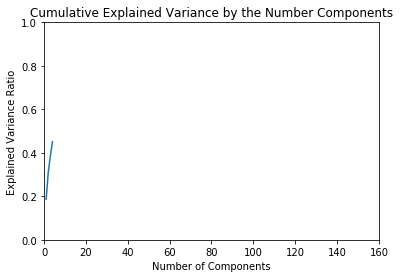

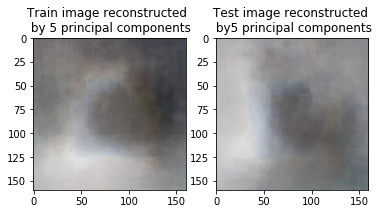

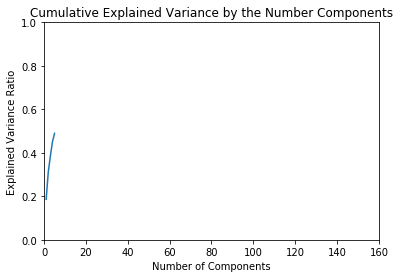

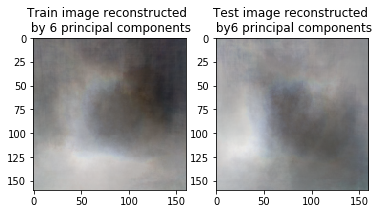

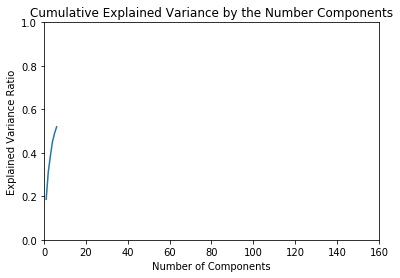

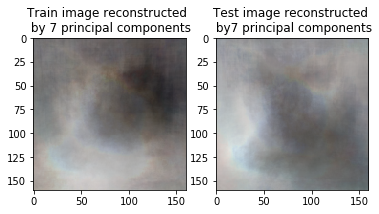

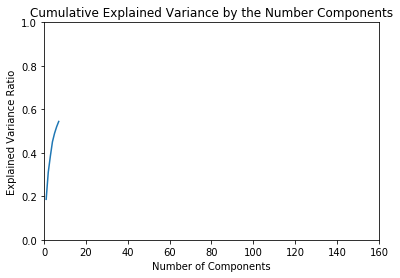

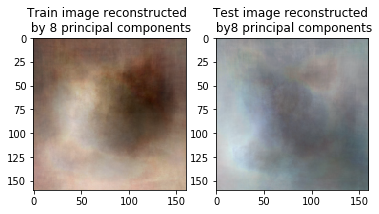

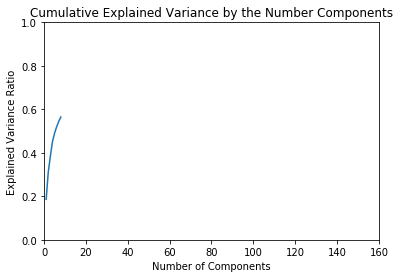

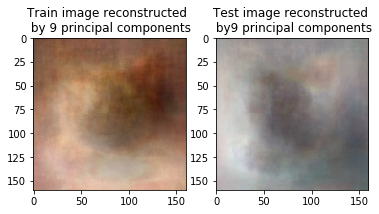

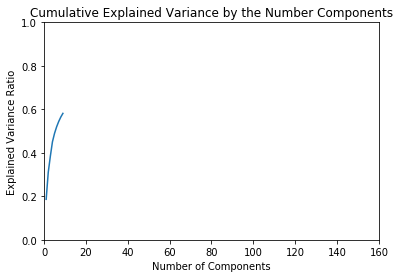

<Figure size 432x288 with 0 Axes>

In [22]:
n_components = []
# can set the range to 161 but for easy upload I'm only gonna try out 10
for i in range(1,10):
    #use PCA to reduce the image dimensions by creating new componenets. 
    pca = PCA(n_components = i)
    cats_train_pca = pca.fit_transform(train_img)
    cats_test_pca = pca.transform(test_img)
    
    # inverse it back to image dimensions 
    cats_test_inverse = pca.inverse_transform(cats_test_pca)
    cats_train_inverse = pca.inverse_transform(cats_train_pca)
    
    #scale it back to 0-1 so it can fit into imshow
    scaler = MinMaxScaler()
    cats_train = scaler.fit_transform(cats_train_inverse)
    cats_test = scaler.transform(cats_test_inverse)
    
    #plot the images
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title('Train image reconstructed \n by '+str(i) + ' principal components')
    ax1.imshow(cats_train[8].reshape(160, 160, 3))
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title('Test image reconstructed \n by'+str(i) + ' principal components')
    ax2.imshow(cats_test[8].reshape(160, 160, 3))
    plt.show() 
    
    ratio = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(ratio)
    n_components.append(i)
    plt.plot(n_components, cum_var_exp)
    plt.title('Cumulative Explained Variance by the Number Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.xlim(0, 160)
    plt.ylim(0, 1)
    plt.show()
    
    plt.tight_layout()